In [1]:
from google import colab
colab.drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import h5py
import numpy as np
from torch.utils.data import Dataset

class SudokuDataset(Dataset):
    def __init__(self, h5_file_path, transform=None):
        self.h5_file_path = h5_file_path
        self.transform = transform

        with h5py.File(h5_file_path, 'r') as f:
            self.images = np.array(f['images'])  # Shape: (N, 84, 84)
            self.labels = np.array(f['labels'])  # Shape: (N,)
        if len(self.images) > len(self.labels):
            print(f"Trimming images from {len(self.images)} to {len(self.labels)} to match labels.")
            self.images = self.images[:len(self.labels)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # Shape: (84, 84)
        label = self.labels[idx]  # Label

        # Reshape and normalize the image
        image = image.reshape(1, 84, 84).astype(np.float32) / 255.0  # Shape: (1, 84, 84)

        return image, label


In [3]:
import torch
from torch.utils.data import DataLoader, Subset
from collections import Counter
from torchvision import transforms

# Dataset transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

test_file_path = '/content/drive/MyDrive/sudoku_testing_set.h5'

test_dataset = SudokuDataset(test_file_path, transform=transform)


test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
all_labels = [test_dataset[i][1] for i in range(len(test_dataset))]  # Get all labels from the train set
class_counts = Counter(all_labels)  # Count samples per class
print("Class Distribution in Training Set:", class_counts)
print(f"Test Dataset Size: {len(test_dataset)}")


Class Distribution in Training Set: Counter({np.True_: 15000, np.False_: 15000})
Test Dataset Size: 30000


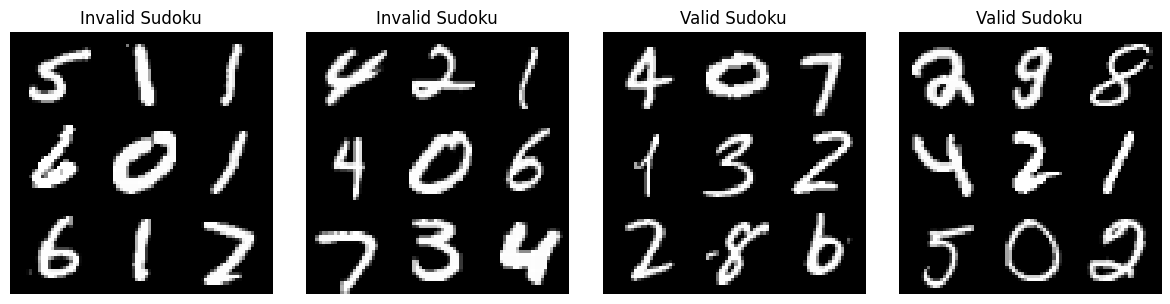

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Initialize counters for each class
class_0_count = 0
class_1_count = 0

# Lists to store selected images for each class
class_0_images = []
class_1_images = []

# Iterate through the test_loader to collect images
for images, labels in test_loader:
    for i in range(len(labels)):
        if labels[i].item() == 0 and class_0_count < 2:  # Check for class 0
            class_0_images.append(images[i])
            class_0_count += 1
        elif labels[i].item() == 1 and class_1_count < 2:  # Check for class 1
            class_1_images.append(images[i])
            class_1_count += 1

        # Stop when we have enough images from both classes
        if class_0_count == 2 and class_1_count == 2:
            break
    if class_0_count == 2 and class_1_count == 2:
        break

# Combine the selected images
selected_images = class_0_images + class_1_images

# Plot the selected images
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    img = selected_images[i].numpy().transpose((1, 2, 0))  # Convert tensor to numpy array
    img = np.clip(img, 0, 1)  # Ensure pixel values are in the valid range

    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"{'Invalid' if i < 2 else 'Valid'} Sudoku")
plt.tight_layout()
plt.show()


# Variational_AutoEncoder

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define a more complex Encoder
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)  # Output: [batch, 32, 42, 42]
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # Output: [batch, 64, 21, 21]
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # Output: [batch, 128, 11, 11]
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # Output: [batch, 256, 6, 6]
        self.fc1 = nn.Linear(256 * 6 * 6, 1024)
        self.fc2_mu = nn.Linear(1024, latent_dim)
        self.fc2_logvar = nn.Linear(1024, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        mu = self.fc2_mu(x)
        logvar = self.fc2_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 128 * 21 * 21)  # Flatten to match the size before upsampling

        # Decoder layers to upsample the image back to 84x84
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1)
    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        z = z.view(z.size(0), 128, 21, 21)

        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        x_reconstructed = torch.sigmoid(self.deconv3(z))

        return x_reconstructed



# Define the VAE model with the classifier head
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logvar


class VAEWithClassifier(nn.Module):
    def __init__(self, latent_dim, vae, num_classes=2):
        super(VAEWithClassifier, self).__init__()
        self.vae = vae
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        reconstructed_images, mu, logvar = self.vae(x)
        class_logits = self.classifier(mu)  # Use `mu` for classification
        return reconstructed_images, mu, logvar, class_logits

# Define the VAE loss function
def vae_loss(reconstructed_images, images, mu, logvar):
    reconstructed_images = reconstructed_images.view(reconstructed_images.size(0), -1)
    images = images.view(images.size(0), -1)

    # Reconstruction loss (Binary Cross-Entropy)
    BCE = F.binary_cross_entropy(reconstructed_images, images, reduction='sum')

    # KL divergence loss
    KL_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss is the sum of reconstruction and KL loss
    return BCE + KL_divergence


In [19]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_and_visualize(model, test_loader, device):
    """
    Evaluate the classification performance of the model and visualize original and reconstructed images.
    Confidence tracking and plotting have been removed.

    Args:
        model: The trained model to be evaluated.
        test_loader: DataLoader containing the test dataset.
        device: Device to run the evaluation on (CPU/GPU).
    """
    all_true_labels = []
    all_pred_labels = []
    images_batch = None
    reconstructions_batch = None

    # Per-class accuracy calculation
    class_correct = [0] * 2  # For 2 classes
    class_total = [0] * 2

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            output = model(images)
            reconstructed_images, _, _, class_logits = output

            # Softmax to get probabilities
            probs = F.softmax(class_logits, dim=1)
            _, pred_labels = torch.max(probs, dim=1)

            # Store predictions and labels
            all_true_labels.extend(labels.cpu().numpy())
            all_pred_labels.extend(pred_labels.cpu().numpy())

            # Per-class accuracy tracking
            for i in range(labels.size(0)):
                label = labels[i].item()
                pred_label = pred_labels[i].item()

                if label == pred_label:
                    class_correct[label] += 1

                class_total[label] += 1

            # Save images for reconstruction visualization
            if batch_idx == 0:
                images_batch = images.cpu().numpy()
                if reconstructed_images is not None:
                    reconstructions_batch = reconstructed_images.cpu().numpy()

    # Overall metrics
    accuracy = accuracy_score(all_true_labels, all_pred_labels)
    precision = precision_score(all_true_labels, all_pred_labels, average='weighted')
    recall = recall_score(all_true_labels, all_pred_labels, average='weighted')
    f1 = f1_score(all_true_labels, all_pred_labels, average='weighted')

    print(f"Classification Accuracy on Test Set: {accuracy * 100:.2f}%")
    for i in range(len(class_correct)):
        if class_total[i] > 0:
            per_class_accuracy = 100 * class_correct[i] / class_total[i]
            print(f"Class {i} Accuracy: {per_class_accuracy:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    # Visualize reconstructions
    if reconstructions_batch is not None:
        visualize_reconstruction(images_batch, reconstructions_batch)


# Function to apply binary thresholding
def apply_threshold(image, threshold=0.5):
    return np.where(image > threshold, 1.0, 0.0)

# Function to visualize original vs reconstructed images
def visualize_reconstruction(original_images, reconstructed_images, threshold=0.5):
    original_images = original_images.squeeze()
    reconstructed_images = reconstructed_images.squeeze()

    original_images = apply_threshold(original_images, threshold)
    reconstructed_images = apply_threshold(reconstructed_images, threshold)

    num_images = 10
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))

    for i in range(num_images):
        axes[0, i].imshow(original_images[i], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Original {i+1}")

        axes[1, i].imshow(reconstructed_images[i], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Reconstructed {i+1}")

    plt.show()

    plt.imshow(original_images[0], cmap='gray')
    plt.axis('off')
    plt.title("Original Image 1")
    plt.show()

    plt.imshow(reconstructed_images[0], cmap='gray')
    plt.axis('off')
    plt.title("Reconstructed Image 1")
    plt.show()


Classification Accuracy on Test Set: 68.56%
Class 0 Accuracy: 73.57%
Class 1 Accuracy: 63.55%
Precision: 0.69
Recall: 0.69
F1 Score: 0.68


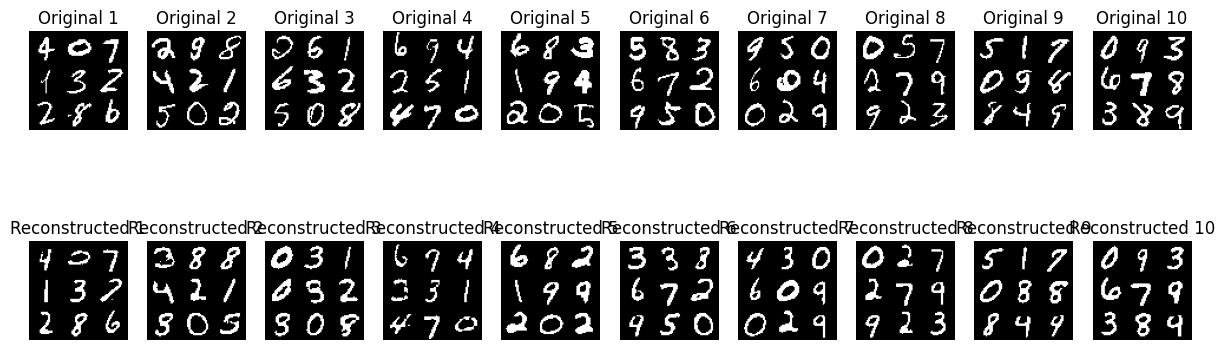

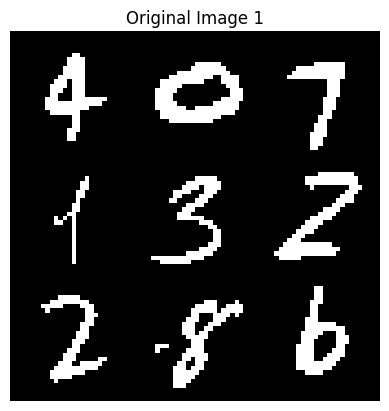

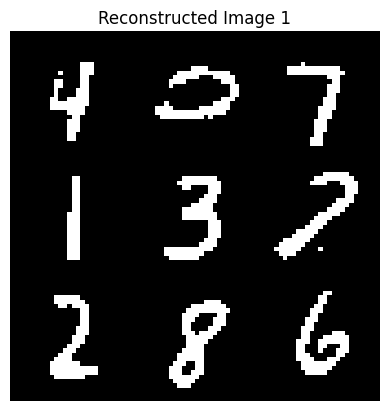

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 128
vae = VAE(latent_dim)
model = VAEWithClassifier(latent_dim, vae)
model.eval()  # Set the model to evaluation mode
model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Models/Variational_AutoEncoder.pth'))  # Adjust path as needed

# Run the evaluation and visualization
evaluate_and_visualize(model, test_loader, device)

# CNN

In [8]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # [B, 16, 84, 84]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                # [B, 16, 42, 42]

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # [B, 32, 42, 42]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # [B, 32, 21, 21]

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # [B, 64, 21, 21]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # [B, 64, 10, 10]

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # [B, 128, 10, 10]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                  # [B, 128, 5, 5]
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),                                          # [B, 128 * 5 * 5]
            nn.Linear(128 * 5 * 5, 128),
            nn.ReLU(),
            nn.Linear(128, 1),                                     # Output: 1 value per input
            nn.Sigmoid()                                           # Probability of class 1
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [22]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def test(model, test_loader, num_classes):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            device = 'cuda'
            images, labels = images.to(device), labels.long().to(device)

            # Forward pass
            outputs = model(images).squeeze(1)  # Shape: [batch_size]
            preds = (outputs > 0.5).float()  # Convert probabilities to 0/1 predictions

            # Collect all predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays for metric calculations
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Metrics
    accuracy = 100 * (all_preds == all_labels).sum() / len(all_labels)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    # Per-class accuracy
    per_class_accuracy = []
    for cls in range(num_classes):
        class_indices = (all_labels == cls)
        class_correct = (all_preds[class_indices] == all_labels[class_indices]).sum()
        class_total = class_indices.sum()
        per_class_acc = 100 * class_correct / class_total if class_total > 0 else 0
        per_class_accuracy.append(per_class_acc)

    print(f"Test Metrics:")
    print(f"  Accuracy: {accuracy:.2f}%")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print("  Per-Class Accuracy:")
    for i, acc in enumerate(per_class_accuracy):
        print(f"    Class {i}: {acc:.2f}%")

    return accuracy, precision, recall, f1, per_class_accuracy


In [23]:
model = SimpleCNN()

model_path = '/content/drive/MyDrive/Models/CNN.pth'
model.load_state_dict(torch.load(model_path))
model = model.cuda()
model.eval()


SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3200, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [26]:
test(model, test_loader, 2)

Test Metrics:
  Accuracy: 87.00%
  Precision: 0.8945
  Recall:    0.8389
  F1 Score:  0.8658
  Per-Class Accuracy:
    Class 0: 90.11%
    Class 1: 83.89%


(np.float64(86.99666666666667),
 0.8945048695528542,
 0.8388666666666666,
 0.865792823476795,
 [np.float64(90.10666666666667), np.float64(83.88666666666667)])

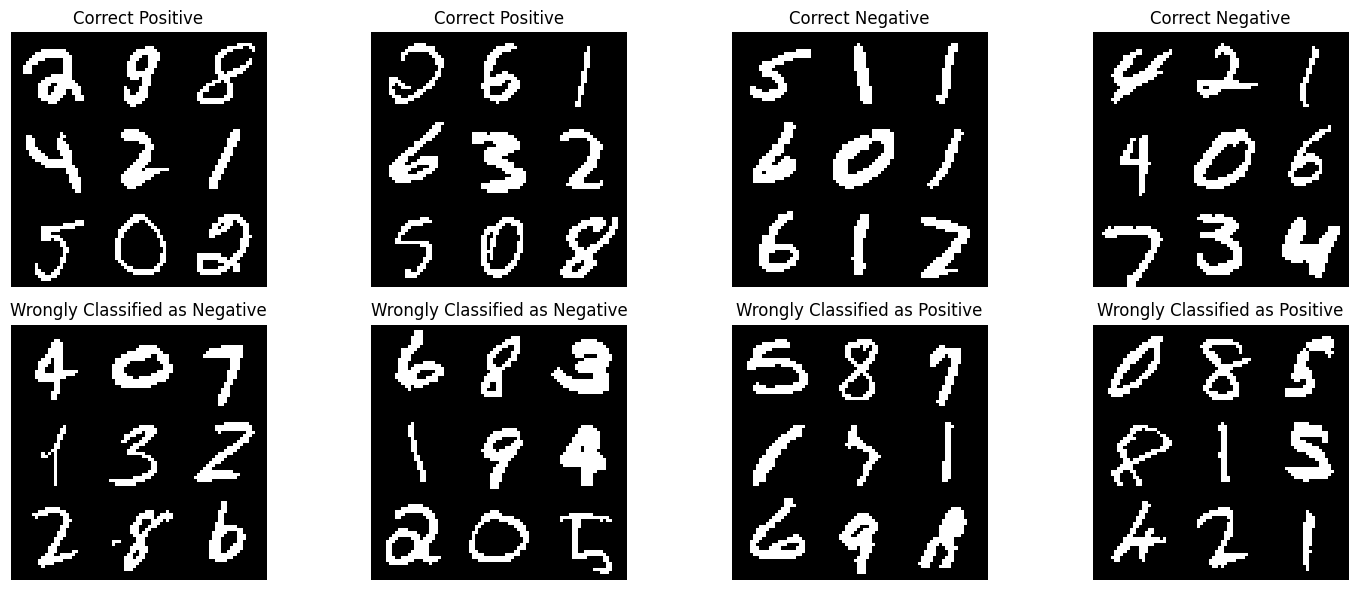

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Function to apply thresholding to images (binary thresholding)
def apply_threshold(image, threshold=0.5):
    """
    Apply binary thresholding to the image.
    Pixel values above the threshold are set to 1 (white), and below are set to 0 (black).

    Args:
        image: Input image as a NumPy array.
        threshold: Threshold value (default: 0.5).

    Returns:
        Thresholded binary image as a NumPy array.
    """
    return np.where(image > threshold, 1.0, 0.0)

# Initialize counters and storage
correct_pos = 0  # Correct positive example count
correct_neg = 0  # Correct negative example count
wrong_pos = 0    # Incorrectly classified positive example count
wrong_neg = 0    # Incorrectly classified negative example count

correct_pos_images = []  # Correct positive images
correct_neg_images = []  # Correct negative images
wrong_pos_images = []    # Incorrectly classified positive images
wrong_neg_images = []    # Incorrectly classified negative images

# Iterate through the test loader
for img, label in test_loader:
    for i in range(len(label)):
        image = img[i].squeeze(0)  # Extract the image and remove the channel dimension

        # Forward pass through the model
        result = model(img[i].unsqueeze(0).cuda()).squeeze(0)  # Model prediction
        preds = (result > 0.5).float()  # Apply threshold for binary classification

        # Check correctness
        if preds.item() == label[i].item():  # Correct classification
            if label[i].item() == 1 and correct_pos < 2:  # Correct positive
                correct_pos_images.append(image)
                correct_pos += 1
            elif label[i].item() == 0 and correct_neg < 2:  # Correct negative
                correct_neg_images.append(image)
                correct_neg += 1
        else:  # Incorrect classification
            if label[i].item() == 1 and wrong_pos < 2:  # Positive classified as negative
                wrong_pos_images.append(image)
                wrong_pos += 1
            elif label[i].item() == 0 and wrong_neg < 2:  # Negative classified as positive
                wrong_neg_images.append(image)
                wrong_neg += 1

        # Stop if all required examples are collected
        if correct_pos == 2 and correct_neg == 2 and wrong_pos == 2 and wrong_neg == 2:
            break
    if correct_pos == 2 and correct_neg == 2 and wrong_pos == 2 and wrong_neg == 2:
        break

# Combine images for display
images_to_display = correct_pos_images + correct_neg_images + wrong_pos_images + wrong_neg_images
titles = (
    ["Correct Positive"] * 2 +
    ["Correct Negative"] * 2 +
    ["Wrongly Classified as Negative"] * 2 +
    ["Wrongly Classified as Positive"] * 2
)

# Plot the selected images
fig, axes = plt.subplots(2, 4, figsize=(15, 6))
axes = axes.ravel()
for i in range(8):
    img = images_to_display[i].numpy()  # Convert tensor to NumPy array
    thresholded_image = apply_threshold(img, threshold=0.5)  # Apply thresholding
    axes[i].imshow(thresholded_image, cmap='gray')
    axes[i].set_title(titles[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()


# Integrated_Gradient

In [16]:
pip install captum


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 115.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

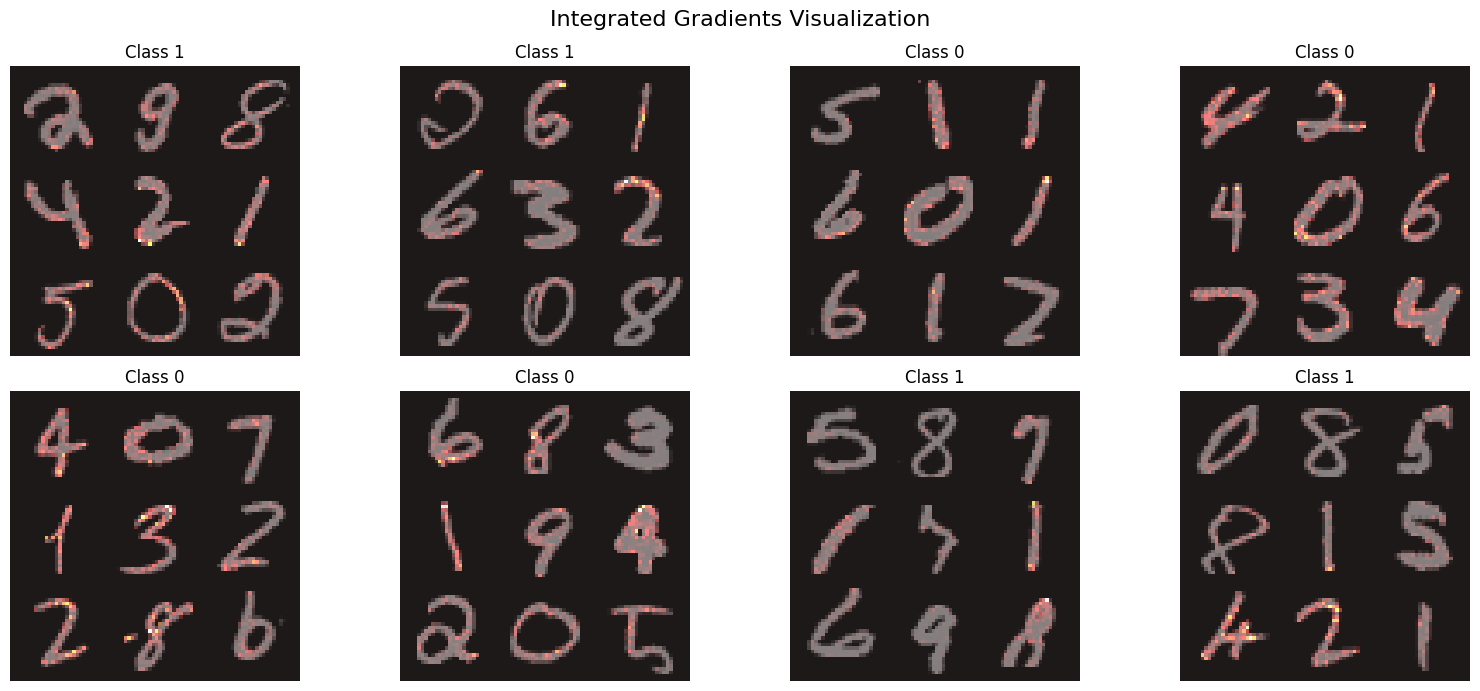

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients

# Put model in eval mode and move to GPU if needed
model.eval().cuda()

# Define the forward function for Integrated Gradients
def model_forward(x):
    return model(x).squeeze(1)  # Output shape: [B]

# Initialize Integrated Gradients
ig = IntegratedGradients(model_forward)

# Plot attributions
fig, axes = plt.subplots(2, 4, figsize=(16, 7))
axes = axes.ravel()

for i, img in enumerate(images_to_display):
    input_img = img.unsqueeze(0).unsqueeze(0).cuda()  # [1, 1, 84, 84]
    input_img.requires_grad_()

    baseline = torch.zeros_like(input_img)

    # Get prediction
    output = model_forward(input_img)
    pred_class = int((output > 0.5).item())

    # Compute attributions (remove target for binary)
    attributions = ig.attribute(input_img, baselines=baseline)
    attributions = attributions.squeeze().detach().cpu().numpy()

    # Normalize
    attributions = np.abs(attributions)
    attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min() + 1e-8)

    # Plot
    axes[i].imshow(img.squeeze().cpu(), cmap='gray', alpha=0.8)
    axes[i].imshow(attributions, cmap='hot', alpha=0.5)
    axes[i].set_title(f"Class {pred_class}")
    axes[i].axis('off')


plt.tight_layout()
plt.suptitle("Integrated Gradients Visualization", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()
